In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

/home/federico/federico/CEEU/bolimpico/venv/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
#!pip install pygeos
#!pip install xgboost

In [2]:
parcelas = gpd.read_file('../data/parcelas_sur_prices_.geojson')

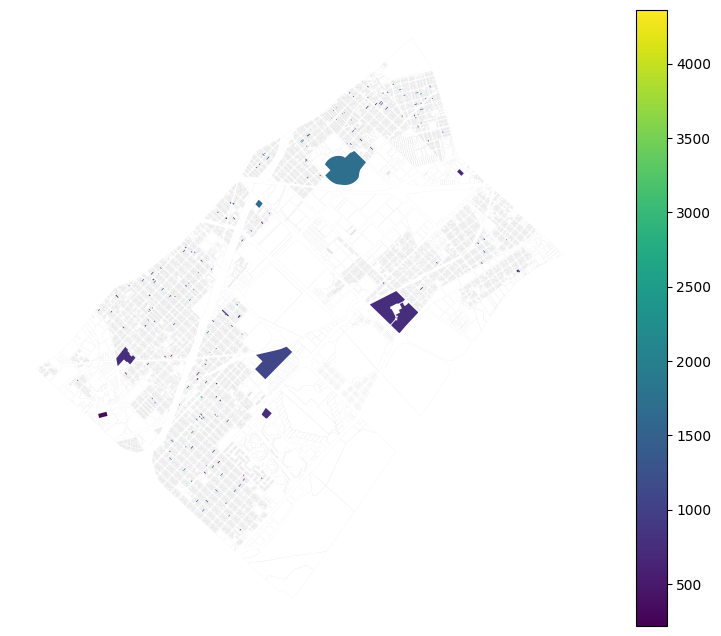

In [3]:
f, ax = plt.subplots(figsize=(12,8))

parcelas.geometry.boundary.plot(ax=ax, color='black', linewidth=0.01)
parcelas[~parcelas['usdm2'].isin([np.nan, np.inf, -np.inf])].plot(column='usdm2', ax=ax, legend=True)
ax.set_axis_off();

In [4]:
parcelas.columns

Index(['fid_1', 'featid1', 'manzana', 'obs', 'parcela', 'seccion', 'smp',
       'partida', 'sup_edif', 'unidades', 'fid_2', 'barrios', 'comuna', 'area',
       'perimeter', 'acres', 'dist_m2', 'hectares', 'usdm2', 'usdm2_f',
       'price_adj', 'geometry'],
      dtype='object')

In [5]:
gkbs = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'

In [6]:
# AREA
parcelas['area'] = parcelas.to_crs(gkbs).geometry.area

In [7]:
valid_geom = parcelas[~parcelas['usdm2'].isna()]

In [8]:
df = parcelas.to_crs(gkbs).sjoin_nearest(valid_geom[['smp','price_adj','usdm2','geometry']].to_crs(gkbs))

In [9]:
len(df)

28092

In [10]:
df['x'], df['y'] = df.geometry.centroid.x, df.geometry.centroid.y

In [11]:
df.columns

Index(['fid_1', 'featid1', 'manzana', 'obs', 'parcela', 'seccion', 'smp_left',
       'partida', 'sup_edif', 'unidades', 'fid_2', 'barrios', 'comuna', 'area',
       'perimeter', 'acres', 'dist_m2', 'hectares', 'usdm2_left', 'usdm2_f',
       'price_adj_left', 'geometry', 'index_right', 'smp_right',
       'price_adj_right', 'usdm2_right', 'x', 'y'],
      dtype='object')

In [12]:
target_var = 'usdm2_left'

In [13]:
expvars = ['sup_edif','unidades','area','usdm2_right','x','y']

In [14]:
df[expvars].isna().any()

sup_edif        True
unidades        True
area           False
usdm2_right    False
x              False
y              False
dtype: bool

In [15]:
df['sup_edif'] = df['sup_edif'].fillna(0).astype(int)
df.unidades.replace({'VILLA SOLDATI': 0}, inplace=True)
df['unidades'] = df['unidades'].fillna(0).astype(int)

In [16]:
df_ = df[~df['usdm2_left'].isna()].copy()

In [17]:
df_[['smp_left','smp_right','usdm2_left','usdm2_right']]

,smp_left,smp_right,usdm2_left,usdm2_right
49,044-149A-006g,044-149A-006g,1078.792857,1078.792857
188,044-147B-018a,044-147B-018a,1149.063107,1149.063107
9869,044-135-003b,044-135-003b,943.737500,943.737500
4454,044-122-020b,044-122-020b,560.007282,560.007282
456,044-143B-012,044-143B-012,714.278468,714.278468
...,...,...,...,...
26191,080-045-008,080-045-008,2550.193333,2550.193333
26321,080-023-024,080-023-024,1971.241546,1971.241546
26854,082-032-036,082-032-036,1743.821782,1743.821782
27381,078-120-018,078-120-018,723.635359,723.635359


In [18]:
########################################################################

In [19]:
from REM.models import *

In [20]:
# Target + Explanatory variables & + train/test split
X, y = df_[expvars], df_[target_var]

data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 15)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [22]:
print_scores(y_test, preds)

RMSE: 377.497556
R_Squared Score : 0.387352


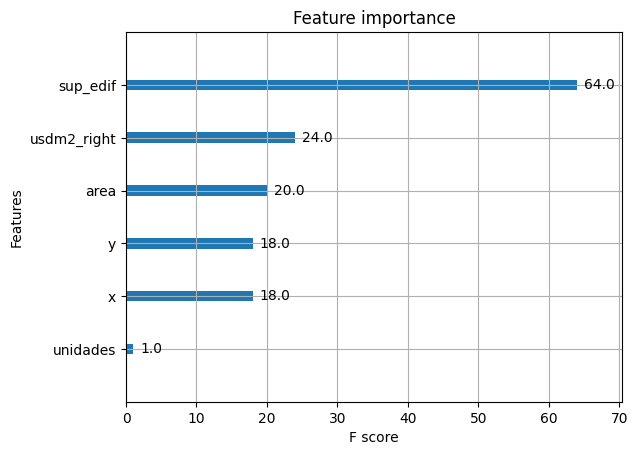

In [23]:
xgb.plot_importance(xg_reg);

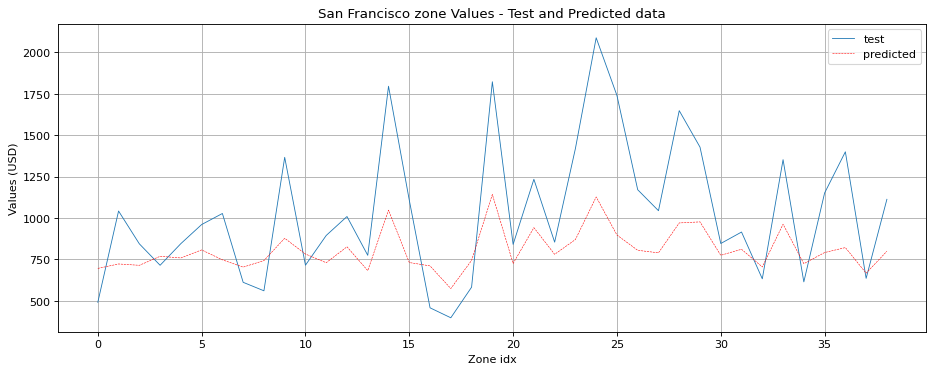

In [24]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds, predicted_name='Values')

In [25]:
hyper_parameters = {
                    'colsample_bytree': [0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], # percentage of features used per tree
                    'learning_rate': np.linspace(0, 0.6, num=20), #step size to prevent overfitting. Range is [0,1]
                    'max_depth': [3,5,10,20,30,40,50], # how deeply each tree is allowed to grow during any boosting round
                    'alpha':[8,16,32,48],
                    'num_boost_round': [15, 30, 100, 500, 1000]#number of trees
                            }

In [26]:
min_rmse_scores = {}

for k in hyper_parameters.keys():
    
    if 'colsample_bytree' in k:
        colsample_bytree_scores = test_cv_parameters(k, hyper_parameters, data_dmatrix)
        min_rmse_scores[k+'_scores'] = colsample_bytree_scores
    
    if 'learning_rate' in k:
        learning_rate_scores = test_cv_parameters(k, hyper_parameters, data_dmatrix)
        min_rmse_scores[k+'_scores'] = learning_rate_scores
        
    if 'max_depth' in k:
        max_depth_scores = test_cv_parameters(k, hyper_parameters, data_dmatrix)
        min_rmse_scores[k+'_scores'] = max_depth_scores
        
    if 'alpha' in k:
        alpha_scores = test_cv_parameters(k, hyper_parameters, data_dmatrix)
        min_rmse_scores[k+'_scores'] = alpha_scores
        
    if 'num_boost_round' in k:
        num_boost_round_scores = test_cv_parameters(k, hyper_parameters, data_dmatrix)
        min_rmse_scores[k+'_scores'] = num_boost_round_scores

Optimizing colsample_bytree
***************************
0.05
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
Optimizing learning_rate
************************
0.0
0.031578947368421054
0.06315789473684211
0.09473684210526316
0.12631578947368421
0.15789473684210525
0.18947368421052632
0.2210526315789474
0.25263157894736843
0.28421052631578947
0.3157894736842105
0.3473684210526316
0.37894736842105264
0.4105263157894737
0.4421052631578948
0.4736842105263158
0.5052631578947369
0.5368421052631579
0.5684210526315789
0.6
Optimizing max_depth
********************
3
5
10
20
30
40
50
Optimizing alpha
****************
8
16
32
48
Optimizing num_boost_round
**************************
15
30
100
500
1000


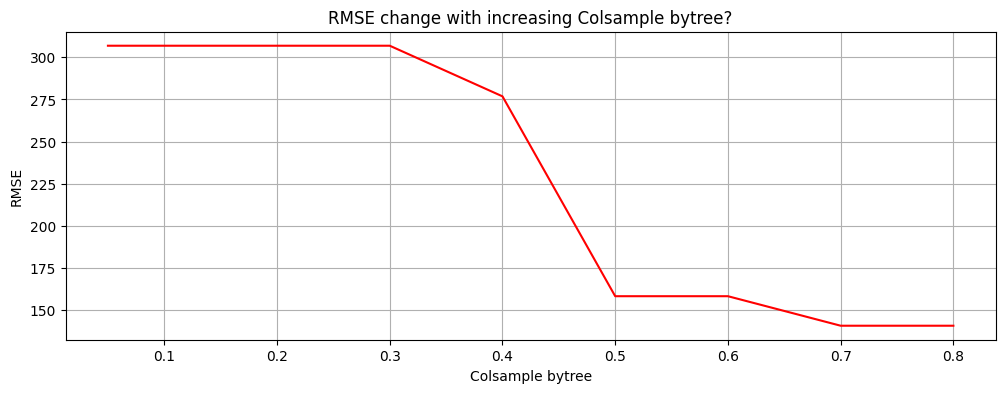

In [27]:
plot_cross_val(alternatives=hyper_parameters['colsample_bytree'],
               results=min_rmse_scores['colsample_bytree_scores'],
               parameter='Colsample bytree', color='red')

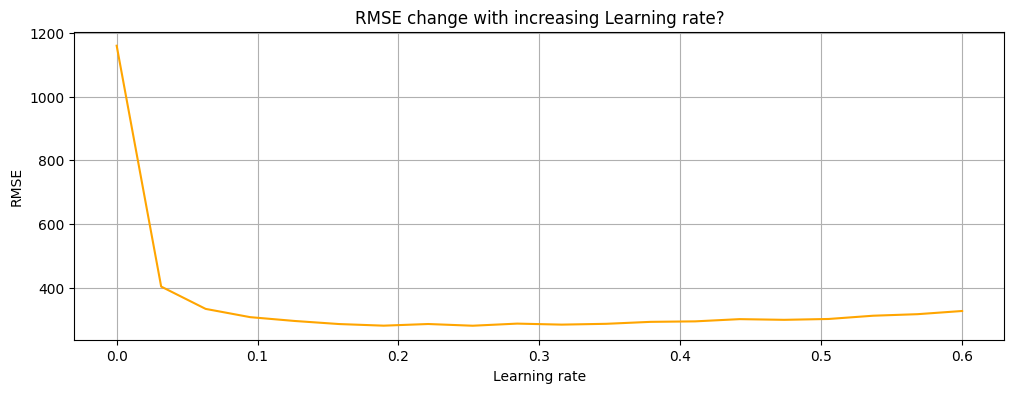

In [28]:
plot_cross_val(alternatives=hyper_parameters['learning_rate'],
               results=min_rmse_scores['learning_rate_scores'],
               parameter='Learning rate', color='orange')

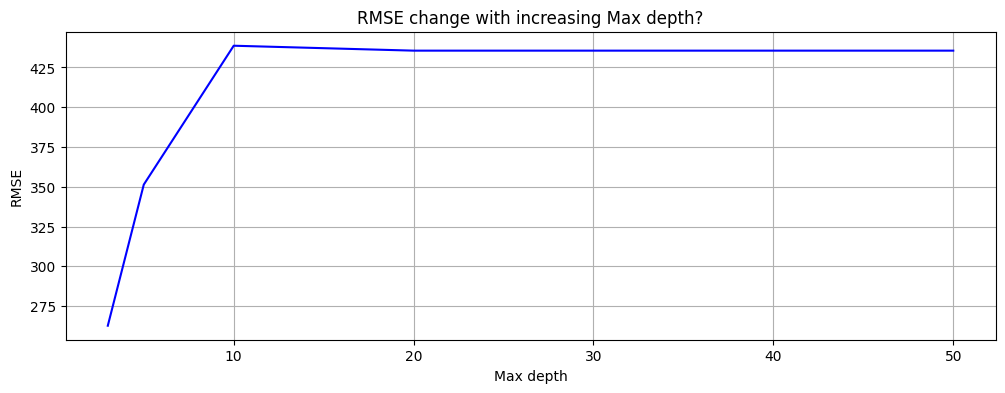

In [29]:
plot_cross_val(alternatives=hyper_parameters['max_depth'],
               results=min_rmse_scores['max_depth_scores'],
               parameter='Max depth', color='blue')

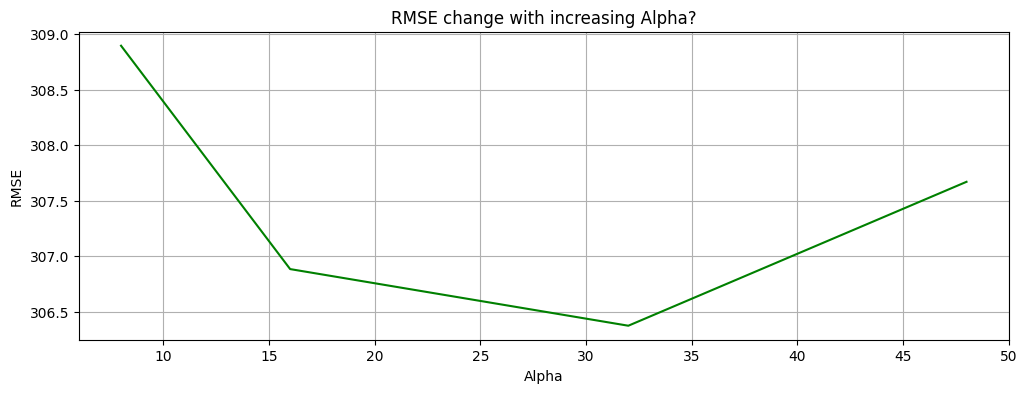

In [30]:
plot_cross_val(alternatives=hyper_parameters['alpha'],
               results=min_rmse_scores['alpha_scores'],
               parameter='Alpha', color='green')

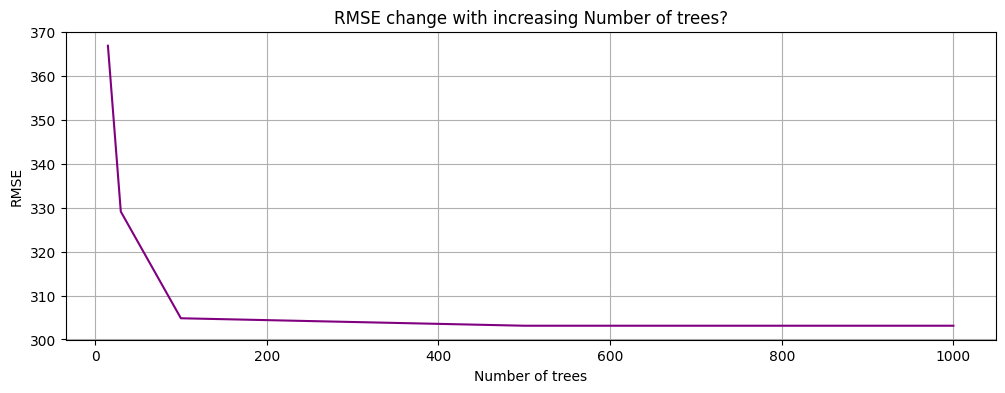

In [31]:
plot_cross_val(alternatives=hyper_parameters['num_boost_round'],
               results=min_rmse_scores['num_boost_round_scores'],
               parameter='Number of trees', color='purple')

In [32]:
best_params = {}

params = ["colsample_bytree", "learning_rate", "max_depth", "alpha", "num_boost_round"]

for p in params:
    o = optimal_hyperparam(dict1=hyper_parameters[p], 
                           dict2=min_rmse_scores[p+'_scores'])
    best_params[p] = o

In [33]:
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.25263157894736843,
 'max_depth': 3,
 'alpha': 32,
 'num_boost_round': 500}

In [34]:
xg_reg_cv = xgb.XGBRegressor(objective ='reg:squarederror',
                             colsample_bytree=best_params['colsample_bytree'],
                             learning_rate=best_params['learning_rate'],
                             max_depth=best_params['max_depth'],
                             alpha=best_params['alpha'],
                             n_estimators=best_params['num_boost_round'],
                             subsample=0.75,
                             gamma=0
                            )

xg_reg_cv.fit(X_train, y_train)

preds_cv = xg_reg_cv.predict(X_test)

In [35]:
print_scores(y_test, preds_cv)

RMSE: 68.216194
R_Squared Score : 0.986025


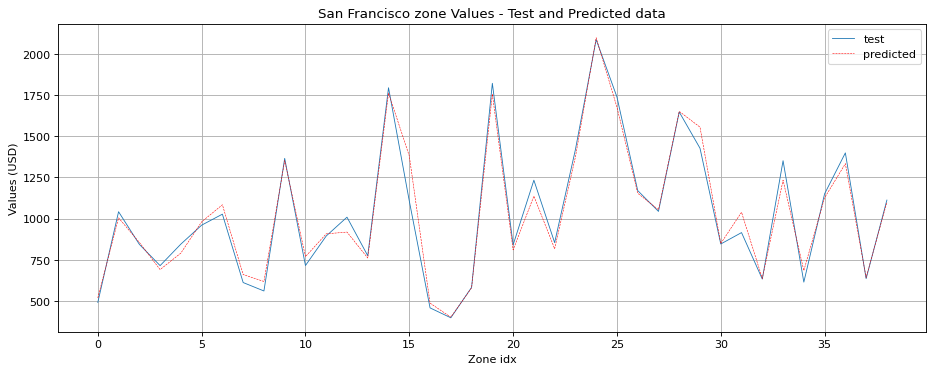

In [36]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds_cv, predicted_name='Values')

In [37]:
to_predict = df[df['usdm2_left'].isna()].copy()

In [38]:
predicted_parcels = xg_reg_cv.predict(to_predict[expvars])

In [39]:
predicted_parcels

array([1123.2625 , 1088.4142 , 1073.8152 , ...,  478.50058,  484.34763,
        480.30548], dtype=float32)

In [40]:
len(to_predict['usdm2_left'])

27901

In [41]:
len(predicted_parcels)

27901

In [42]:
to_predict['usdm2_left'] = predicted_parcels

In [43]:
observed = df[~df['usdm2_left'].isna()].copy()

In [44]:
predicted = pd.concat([to_predict, observed])

In [45]:
type(predicted)

geopandas.geodataframe.GeoDataFrame

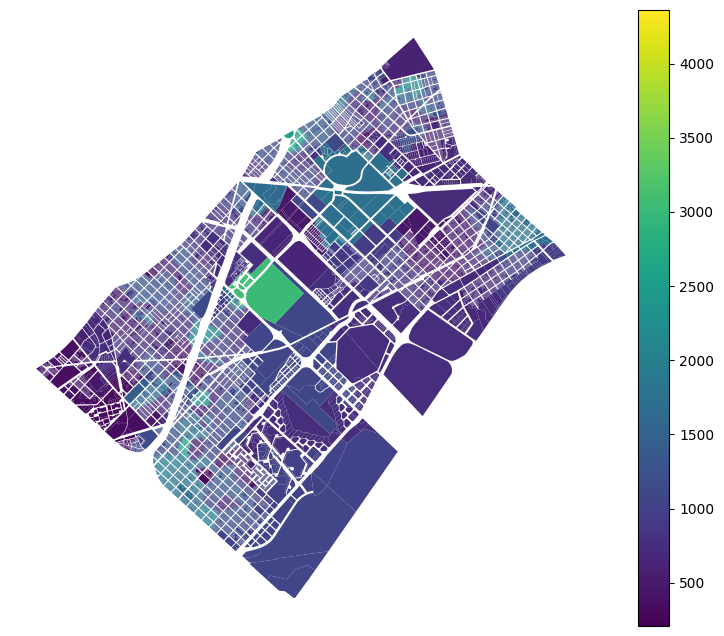

In [47]:
f, ax = plt.subplots(figsize=(12,8))

#parcelas.to_crs(predicted.crs).geometry.boundary.plot(ax=ax, color='black', linewidth=0.01)
predicted.plot(column='usdm2_left', ax=ax, legend=True)
ax.set_axis_off();

In [59]:
precios = predicted[['smp','usdm2_left']].reset_index().drop(columns='index')

#precios.to_csv('../data/usdm2_parcela_AREA.csv')